# Evaluating Topic Models with Word Embedding

A topic is 'good' if 
- the terms describing it are *coherent*. Many [coherence metrics](http://qpleple.com/topic-coherence-to-evaluate-topic-models/) are available and `gensim` [has implemented](https://markroxor.github.io/gensim/static/notebooks/topic_coherence_tutorial.html) a few of them. [This study](http://eprints.gla.ac.uk/119284/1/119284.pdf) shows that word embedding yields a better performance than those coherence metrics. 
- the documents associated with it are *semantically similar*. There are many ways to measure document similarity, and we can use word embedding again here.

*Following this direction, this notebook will look into the use of word embedding in evluating topic models.*

In [1]:
import nlp
# import json

import numpy as np
import pandas as pd

from sklearn import manifold

import matplotlib.pyplot as plt
%matplotlib inline  
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

from gensim.models import KeyedVectors

from sklearn.preprocessing import MinMaxScaler

%load_ext autoreload
%autoreload 2

##  Topic modelling with LDA
I will use a small [Lee Background Corpus](https://hekyll.services.adelaide.edu.au/dspace/bitstream/2440/28910/1/hdl_28910.pdf), which contains 300 short news.

In [2]:
data = nlp.load_file('../data/lee.txt')
docs = nlp.preprocess(data)
len(data), data[0], docs[0]

(300,
 'Hundreds of people have been forced to vacate their homes in the Southern Highlands of New South Wales as strong winds today pushed a huge bushfire towards the town of Hill Top. A new blaze near Goulburn, south-west of Sydney, has forced the closure of the Hume Highway. At about 4:00pm AEDT, a marked deterioration in the weather as a storm cell moved east across the Blue Mountains forced authorities to make a decision to evacuate people from homes in outlying streets at Hill Top in the New South Wales southern highlands. An estimated 500 residents have left their homes for nearby Mittagong. The New South Wales Rural Fire Service says the weather conditions which caused the fire to burn in a finger formation have now eased and about 60 fire units in and around Hill Top are optimistic of defending all properties. As more than 100 blazes burn on New Year\'s Eve in New South Wales, fire crews have been called to new fire at Gunning, south of Goulburn. While few details are availabl

Apply LDA with 10 topics.

In [3]:
lda = nlp.build_lda(docs, num_topics=10)
lda.print_topics()

[(0,
  '0.030*"afghanistan" + 0.025*"bin" + 0.025*"force" + 0.022*"laden" + 0.018*"qaeda" + 0.015*"afghan" + 0.015*"taliban" + 0.014*"united" + 0.014*"fighter" + 0.012*"state"'),
 (1,
  '0.018*"centre" + 0.016*"rate" + 0.015*"per" + 0.013*"cent" + 0.013*"police" + 0.012*"one" + 0.010*"three" + 0.010*"time" + 0.010*"bank" + 0.010*"australian"'),
 (2,
  '0.047*"fire" + 0.026*"new" + 0.018*"area" + 0.018*"sydney" + 0.017*"south" + 0.016*"company" + 0.013*"today" + 0.013*"wind" + 0.012*"also" + 0.011*"one"'),
 (3,
  '0.053*"palestinian" + 0.035*"israeli" + 0.031*"arafat" + 0.017*"attack" + 0.017*"israel" + 0.016*"hamas" + 0.014*"leader" + 0.014*"official" + 0.013*"gaza" + 0.013*"suicide"'),
 (4,
  '0.025*"worker" + 0.024*"qantas" + 0.023*"union" + 0.019*"action" + 0.018*"australian" + 0.016*"airline" + 0.014*"metre" + 0.014*"industrial" + 0.014*"company" + 0.013*"test"'),
 (5,
  '0.032*"report" + 0.031*"commission" + 0.030*"people" + 0.017*"union" + 0.016*"royal" + 0.014*"job" + 0.014*"hea

To project documents, we need to produce a matrix `(num_docs, num_topics)`, in which each row is a vector of topic probability. 

In [4]:
def build_docs_topics_matrix(lda, corpus):
    'Return a matrix representation of documents x topics.'
    
    def doc2vec(doc):
        topics = lda.get_document_topics(doc)
        v = np.zeros(lda.num_topics)

        for t, p in topics:
            v[t] = p

        return v.reshape(1, -1)
    
    return np.concatenate([doc2vec(doc) for doc in corpus])

In [5]:
corpus = [lda.id2word.doc2bow(doc) for doc in docs]
doc_topic_matrix = build_docs_topics_matrix(lda, corpus)
doc_topic_matrix.shape

(300, 10)

We also need to find the strongest topic associated with each document to see how the topics distributed.

In [6]:
def get_strongest_topics(lda, corpus):
    'Return a list of the strongest topic for each document.'
    
    def get_one(doc):
        topics = lda.get_document_topics(doc, minimum_probability=0.01)
        strongest_topic = max(topics, key=lambda x: x[1])
        return strongest_topic[0]

    return [get_one(doc) for doc in corpus]

In [7]:
topic_ids = get_strongest_topics(lda, corpus)
topic_ids

[2,
 7,
 9,
 7,
 9,
 6,
 8,
 2,
 2,
 2,
 2,
 2,
 7,
 3,
 3,
 1,
 8,
 8,
 9,
 2,
 1,
 9,
 9,
 8,
 2,
 2,
 7,
 8,
 7,
 3,
 5,
 1,
 2,
 2,
 7,
 0,
 2,
 8,
 1,
 2,
 2,
 0,
 2,
 9,
 3,
 7,
 2,
 8,
 2,
 2,
 0,
 5,
 8,
 9,
 1,
 8,
 0,
 7,
 0,
 8,
 3,
 6,
 2,
 1,
 6,
 0,
 9,
 4,
 3,
 7,
 6,
 7,
 8,
 6,
 7,
 7,
 9,
 1,
 9,
 1,
 9,
 3,
 7,
 6,
 1,
 3,
 9,
 2,
 0,
 1,
 6,
 4,
 1,
 3,
 7,
 9,
 2,
 0,
 0,
 2,
 6,
 4,
 9,
 4,
 4,
 1,
 9,
 0,
 1,
 2,
 3,
 4,
 4,
 1,
 0,
 9,
 3,
 4,
 8,
 9,
 4,
 1,
 7,
 5,
 9,
 1,
 1,
 0,
 4,
 1,
 4,
 3,
 8,
 0,
 3,
 4,
 9,
 4,
 9,
 8,
 0,
 0,
 0,
 3,
 9,
 3,
 8,
 9,
 3,
 5,
 4,
 5,
 3,
 0,
 7,
 7,
 4,
 8,
 5,
 0,
 7,
 4,
 9,
 7,
 9,
 9,
 0,
 0,
 4,
 9,
 1,
 9,
 9,
 3,
 9,
 4,
 0,
 3,
 6,
 4,
 7,
 1,
 8,
 0,
 3,
 6,
 7,
 4,
 2,
 9,
 6,
 8,
 0,
 9,
 7,
 4,
 1,
 3,
 6,
 5,
 0,
 3,
 5,
 4,
 1,
 4,
 6,
 4,
 3,
 7,
 7,
 1,
 8,
 8,
 1,
 5,
 6,
 7,
 7,
 1,
 3,
 1,
 2,
 2,
 8,
 8,
 0,
 3,
 9,
 9,
 8,
 1,
 4,
 0,
 7,
 3,
 8,
 1,
 5,
 7,
 1,
 4,
 3,
 0,
 1,
 1,
 4,
 2,
 9,
 0,


## Projection of documents based on topics

In [8]:
def compute_tsne(vectors):
    'Return a 2D projection of high-dimensional vectors.'
    return manifold.TSNE(perplexity=100, random_state=0).fit_transform(vectors)

In [9]:
doc_coords = compute_tsne(doc_topic_matrix)
doc_coords

array([[  3.86190557e+00,  -1.03153443e+00],
       [  6.31991804e-01,   3.08979917e+00],
       [ -9.01227593e-01,   2.80223817e-01],
       [  1.35234070e+00,   1.38300955e+00],
       [  1.60684371e+00,  -3.94959211e-01],
       [ -2.03508282e+00,  -2.91792798e+00],
       [  8.66348863e-01,  -3.52769017e+00],
       [  3.12475777e+00,  -1.36806536e+00],
       [  3.86348462e+00,  -1.03120089e+00],
       [  2.97498989e+00,  -1.13006842e+00],
       [  3.07827425e+00,  -8.58475208e-01],
       [  3.84218335e+00,  -1.03592539e+00],
       [  6.23183846e-01,   3.09790421e+00],
       [  3.07529950e+00,   2.91707397e+00],
       [  3.27775311e+00,   5.48014402e+00],
       [  4.49487209e+00,  -2.84907007e+00],
       [  1.04989970e+00,  -3.24000621e+00],
       [  1.30503190e+00,  -3.48221302e+00],
       [ -9.26397324e-01,   2.78796583e-01],
       [  2.81971288e+00,  -1.60800278e+00],
       [  4.74661732e+00,  -3.31048441e+00],
       [ -6.21576667e-01,  -2.23972276e-01],
       [ -

In [10]:
def plot_projection(coords, topic_ids):
    'Plot documents and color code their topics.'
    df = pd.DataFrame(data=np.c_[coords, topic_ids], columns= ['x', 'y', 'topic'])
    df.topic = df.topic.astype(int)
    sns.lmplot(data=df, x='x', y='y', hue='topic', palette='Set1', fit_reg=False, size=6, aspect=1.6)

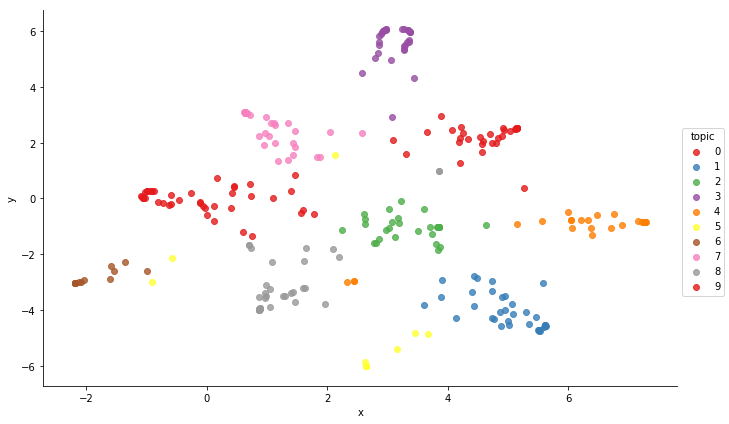

In [11]:
plot_projection(doc_coords, topic_ids)

Great! We can see clear clusters of documents by topics. It doesn't mean that the resultant topics are good because the projection and the topic ID use the same source of information: the (document, topic) distribution. It shows that t-sne projection is quite good. Let's try other projections.

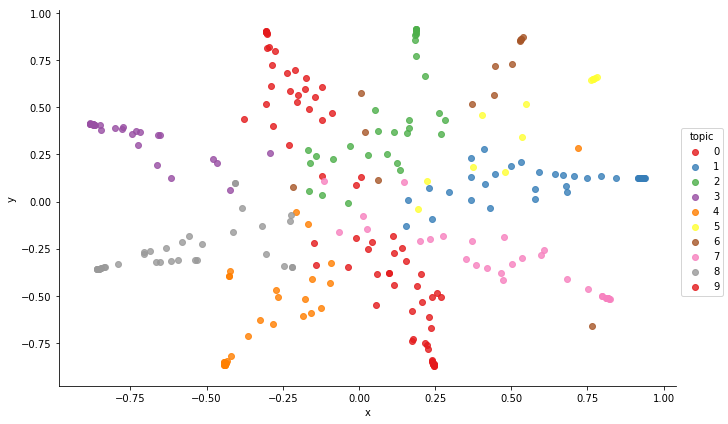

In [12]:
plot_projection(manifold.MDS().fit_transform(doc_topic_matrix), topic_ids)

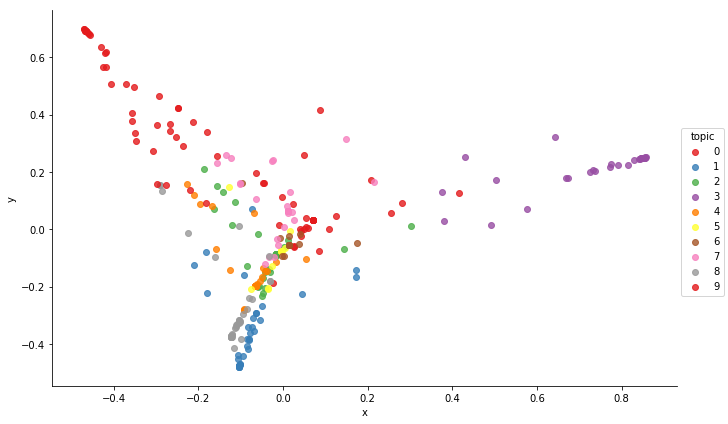

In [13]:
from sklearn import decomposition
plot_projection(decomposition.PCA(n_components=2).fit_transform(doc_topic_matrix), topic_ids)

It looks like t-sne > MDS > PCA (with default parameters).

## Projection of documents with doc2vec

/anaconda3/lib/python3.6/site-packages/sklearn/neighbors/base.py:371: RuntimeWarning: invalid value encountered in sqrt
  result = np.sqrt(dist[sample_range, neigh_ind]), neigh_ind


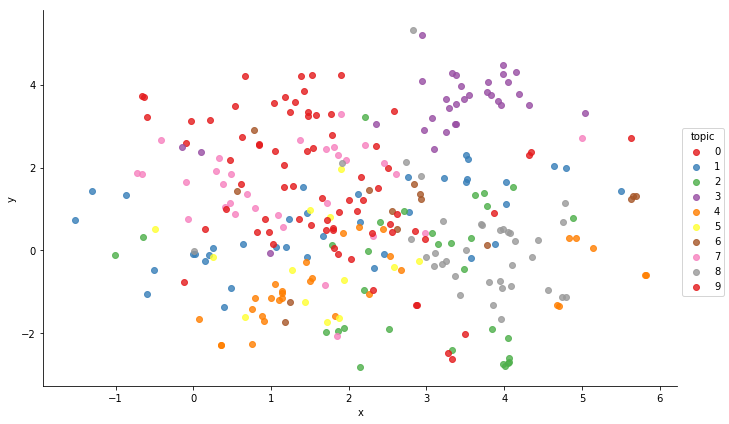

In [14]:
doc2vec = nlp.build_doc2vec(docs)
doc2vec_matrix = np.concatenate([doc2vec.docvecs[i].reshape(1, -1) for i in range(len(doc2vec.docvecs))])
plot_projection(compute_tsne(doc2vec_matrix), topic_ids)

We can see some structure there, but not as clear as the projection using doc-topic matrix.

## Color-coding documents with similarity
I think of two ways: 
- project doc embeddings to 3D and use the coordinates as RGB colors
- use [HSL color space](https://hu.wikipedia.org/wiki/F%C3%A1jl:Hsl-hsv_models.svg) with fixed value of L=0.5, so we map the 2D projection to a color wheel

### 3D projection as RGB

In [16]:
def plot3d(coords, colors):
    fig = plt.figure(figsize=(12,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(coords[:,0], coords[:,1], coords[:,2], c=colors, s=50)

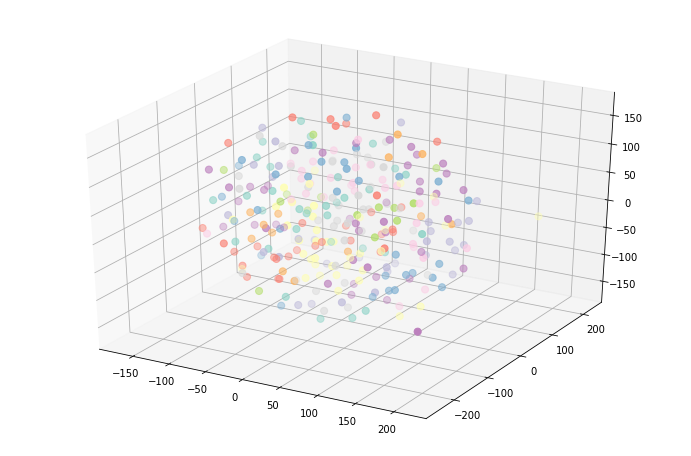

In [17]:
colors = [sns.color_palette('Set3', 10)[t] for t in topic_ids]
doc_coords3d = manifold.TSNE(perplexity=100, random_state=0, n_components=3).fit_transform(doc_topic_matrix)
plot3d(doc_coords3d, colors)

Well, 3d t-sne projection doesn't look good. Let's try MDS.

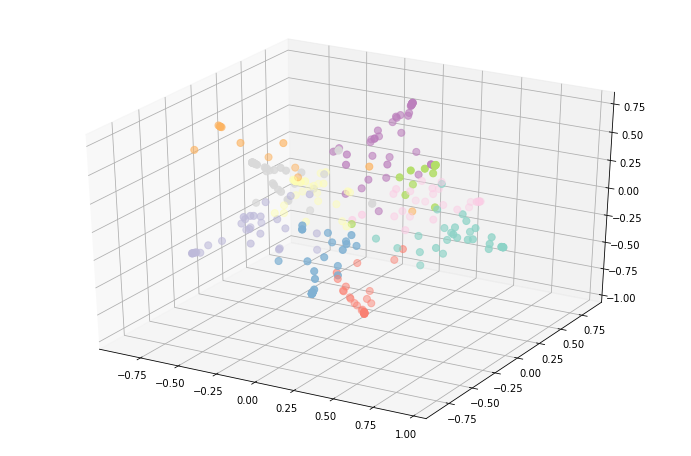

In [18]:
doc_coords3d = manifold.MDS(n_components=3).fit_transform(doc_topic_matrix)
plot3d(doc_coords3d, colors)

Wow, much better! Now, instead of coloring based on topics, I will color using the 3d coordinates.

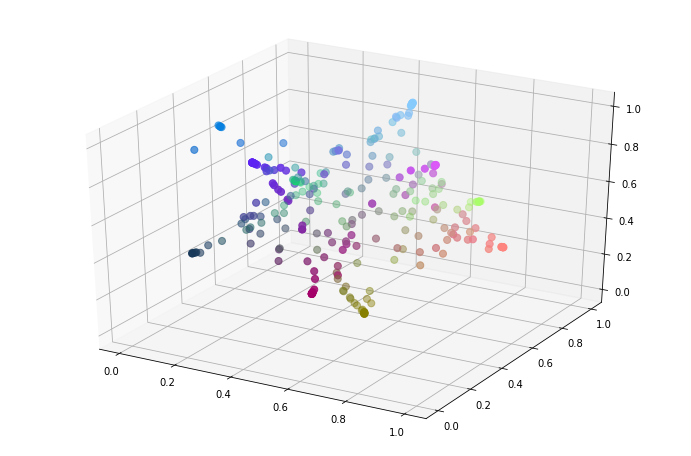

In [19]:
doc_coords3d = MinMaxScaler().fit_transform(doc_coords3d) # rgb color space requires 0-1 components
plot3d(doc_coords3d, doc_coords3d)

### 2D projection as HSL color wheel